In [15]:
from typing import Callable, List, Tuple

import pytorch_lightning as pl
import torch
import torch.nn.functional as F
from torch import nn
from torch.distributions.distribution import Distribution
from pytorch_lightning.loggers import TensorBoardLogger
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [16]:
from NFconstants import N_nod, Beta, a, K_nod
from NFandist import get_O
from NFandist import get_diag
from NFandist import get_C

def set_random_seed(seed):
    torch.manual_seed(seed)
O=(torch.tensor(get_O(N_nod)).float()).to(device)
Ot=(torch.t(O)).to(device)
print(Ot.requires_grad)


#C=(torch.tensor(get_C(N_nod,Beta)).float()).to(device)
#Ct=(torch.t(C)).to(device)




False


In [17]:
class AffineCouplingLayer(nn.Module):
    def __init__(
        self,
        theta: nn.Module,
        split,
        swap: int
    ):
        super().__init__()
        self.theta = theta
        self.split = split
        self.swap = swap

    def g(self, z: torch.Tensor,params=torch.tensor([])) -> torch.Tensor:
        """g : z -> x. The inverse of f."""
        mask1=self.split[self.swap]
        mask2=self.split[(self.swap+1)%2]
        z1, z2 = z[:,mask1], z[:,mask2]
        z1=torch.cat((z1,params),dim=-1)
        t, s = self.theta(z1)
        x2 = z2 * torch.exp(s) + t
        log_det = s.sum(-1) 
        z[:,mask2]=x2
        return z, log_det
    """
    def f(self, x: torch.Tensor) -> torch.Tensor:
        f : x -> z. The inverse of g.
        x2, x1 = self.split(x,self.swap)
        t, s = self.theta(x1)
        z1, z2 = x1, x2 * torch.exp(s) + t 
        log_det = s.sum(-1) 
        return torch.cat((z1, z2), dim=-1), log_det
    """    

In [18]:
class D(nn.Linear):
    def __init__(self,n):
        super().__init__(n,1,bias=False)
        self.n=n
        self.d_ind=[(n+1)*k for k in range(n)]
    
    def anti_flatten(self):
        n=self.n
        D=torch.zeros((n**2)).to(device)
        D[self.d_ind]=self.weight.to(device)
        D=torch.reshape(D,(n,n)).to(device)
        return D        
            
    def log_abs_det(self):
        ABS=torch.abs(self.weight)
        l=torch.log(ABS)
        lad=torch.sum(l)
        return lad
    
    def forward(self,x):
        D=(self.anti_flatten()).to(x.device)
        return torch.matmul(x,D)
    
    def g(self,z,params):
        lad=self.log_abs_det()
        return self.forward(z),  lad * torch.ones((z.shape[0])).to(z.device)
        
    def adj(self,mat):
        Lw=self.anti_flatten()
        Lwt=torch.t(Lw)
        D=torch.matmul(Lwt,torch.matmul(mat,Lw))
        return D
    

In [19]:
class CubicCouplingLayer(nn.Module):
    def __init__(
        self,
        theta,
        split,
        swap: int,
        reg=1
    ):
        super().__init__()
        self.theta = theta
        self.split = split
        self.swap = swap
        self.reg=reg
        
    def g(self, z: torch.Tensor,params=torch.tensor([])) -> torch.Tensor:
        """g : z -> x. The inverse of f."""
        mask1=self.split[self.swap]
        mask2=self.split[(self.swap+1)%2]
        z1, z2 = z[:,mask1], z[:,mask2]
        z1=torch.cat((z1,params),dim=-1)
        t, s = self.theta(z1)
        x2 = z2 + torch.exp(s-self.reg) * (z2) ** 3 + t
        log_det = (torch.log(1+3 * torch.exp(s-self.reg) * (z2) ** 2)).sum(-1)
        z[:,mask2]=x2
        return z, log_det    



In [20]:
def get_split_masks(dim=N_nod):
    mask1=list(range(0,dim,2))
    mask2=list(range(1,dim,2))
    split_masks=[mask1,mask2]
    return split_masks
    

In [21]:
#split_masks=get_split_masks()

In [22]:
def get_pair_split_masks(dim=N_nod):
    mask1=list(range(0,dim,4))
    mask2=list(range(2,dim,4))
    mask1=(mask1+list(map(lambda x:x+1,mask1)))
    mask2=(mask2+list(map(lambda x:x+1,mask2)))
    mask1.sort()
    mask2.sort()
    split_masks=[mask1,mask2]
    return split_masks

In [23]:
#print(get_pair_split_masks(32))

In [24]:
class NormalizingFlow(nn.Module):
    
    def __init__(self, latent: Distribution, flows: List[nn.Module], conv_flows = [], ort=False):
        super().__init__()
        self.latent = latent
        self.flows = flows
        self.ort = ort
        self.conv_flows = conv_flows

    def latent_sample(self, num_samples: int = 1) -> torch.Tensor:
        z=self.latent.sample((num_samples,))
        return z        

    def sample(self, num_samples: int = 1) -> torch.Tensor:
        """Sample a new observation x by sampling z from
        the latent distribution and pass through g."""
        z=(self.latent_sample(num_samples))
        with torch.no_grad():
            x, _ = self.g(z)
        return x 
    

    def g(self, z: torch.Tensor,params=torch.tensor([])) -> torch.Tensor:
        
        #x, sum_log_abs_det = z, torch.ones(z.size(0)).to(z.device)
        x, sum_log_abs_det = z, torch.zeros(z.size(0)).to(z.device)
        for flow in reversed(self.flows):
            x, log_abs_det = flow.g(x,params)
            sum_log_abs_det += log_abs_det
        
        if self.ort:
            x=torch.matmul(x,Ot.to(x.device))
        
        #x=x*a    
        
        for flow in reversed(self.conv_flows):
            x, log_abs_det = flow.g(x)
            sum_log_abs_det += log_abs_det
        return x, sum_log_abs_det
    
        
    def __len__(self) -> int:
        return len(self.flows)
    
 
"""
    def g_steps(self, z: torch.Tensor) -> List[torch.Tensor]:
        Maps latent variable z to observation x
        and stores intermediate results.
        
        xs = [z]
        for flow in reversed(self.flows):
            xs.append(flow.g(xs[-1]))
        return xs

    
    def latent_log_prob(self, z: torch.Tensor) -> torch.Tensor:
        llp=self.latent.log_prob(z)
        sum_llp= torch.sum(llp,axis=-1)
        return sum_llp
 
    
    def f(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:  #forward
        Maps observation x to latent variable z.
        Additionally, computes the log determinant
        of the Jacobian for this transformation.
        Inveres of g.
        
        z, sum_log_abs_det = x, torch.ones(x.size(0)).to(x.device)
        for flow in self.flows:
            z, log_abs_det = flow.f(z)
            sum_log_abs_det += log_abs_det

        return z, sum_log_abs_det
"""
    

'\n    def g_steps(self, z: torch.Tensor) -> List[torch.Tensor]:\n        Maps latent variable z to observation x\n        and stores intermediate results.\n        \n        xs = [z]\n        for flow in reversed(self.flows):\n            xs.append(flow.g(xs[-1]))\n        return xs\n\n    \n    def latent_log_prob(self, z: torch.Tensor) -> torch.Tensor:\n        llp=self.latent.log_prob(z)\n        sum_llp= torch.sum(llp,axis=-1)\n        return sum_llp\n \n    \n    def f(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:  #forward\n        Maps observation x to latent variable z.\n        Additionally, computes the log determinant\n        of the Jacobian for this transformation.\n        Inveres of g.\n        \n        z, sum_log_abs_det = x, torch.ones(x.size(0)).to(x.device)\n        for flow in self.flows:\n            z, log_abs_det = flow.f(z)\n            sum_log_abs_det += log_abs_det\n\n        return z, sum_log_abs_det\n'

In [25]:
class RGflows(nn.Module):
    
    def __init__(self,latent: Distribution ,nflist, masks):
        super().__init__()
        self.latent=latent
        self.nflist = nflist
        self.masks=masks

    def latent_sample(self, num_samples: int = 1) -> torch.Tensor:
        z=self.latent.sample((num_samples,))
        return z        

    def sample(self, num_samples: int = 1) -> torch.Tensor:
        """Sample a new observation x by sampling z from
        the latent distribution and pass through g."""
        z=(self.latent_sample(num_samples))
        with torch.no_grad():
            x, _ = self.g(z)
        return x 
    

    def g(self, z: torch.Tensor,params=torch.tensor([])) -> torch.Tensor:
        
        sum_log_abs_det = torch.zeros(z.size(0)).to(z.device)
        params=torch.tensor([]).to(z.device)
        for i in range(len(self.nflist)):
            x=z[:,self.masks[i]]
            x, log_abs_det = ((self.nflist)[i]).g(x,params)
            sum_log_abs_det += log_abs_det
            params=torch.cat((params,x),dim=-1)
            z[:,self.masks[i]]=x
        z=torch.matmul(z,Ot.to(z.device))    
        return z, sum_log_abs_det
    
        
    def __len__(self) -> int:
        return len(self.flows)
    
    def forward(self,z):
        t=z.clone()
        x=self.g(t)[0]
        del(t)
        return x 
    
 

    

In [26]:
class ThetaNetwork(nn.Module):
    def __init__(
        self,
        in_dim: int,
        out_dim: int,
        num_hidden: int,
        hidden_dim: int,
        num_params: int,
        p_drop: float,
    ):
        super().__init__()
        self.input = nn.Linear(in_dim, hidden_dim)
        self.hidden = nn.ModuleList(
            [nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.Dropout(p=p_drop),
                nn.LayerNorm(hidden_dim)
            ) for _ in range(num_hidden)]
        )

        self.num_params = num_params
        self.out_dim = out_dim
        self.dims = nn.Linear(hidden_dim, out_dim * num_params)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.leaky_relu(self.input(x),negative_slope=0.01)
        for h in self.hidden:
            x = F.leaky_relu(h(x),negative_slope=0.01)

        batch_params = self.dims(x).reshape(x.size(0), self.out_dim, -1) 
        params = batch_params.chunk(self.num_params, dim=-1) 
        return [p.squeeze(-1) for p in params]
    

In [27]:
m=2
X=list(range(N_nod))
Y=[]
for i in range(1,K_nod): Y.append(list(filter(lambda x: (x%(2**(K_nod-i))==0) and x%(2**(K_nod-i+1))!=0 ,X)))


Z=[]
for i in range(m-1):Z+=Y[i]
Z.append(0)
Z=Z+Z
for i in range(2**(m-1)):Z[i]+=1
Z.sort()

RGmasks=[]
RGmasks.append(Z)
for i in range(m-1,K_nod-1):
    Z=Y[i]+Y[i]
    for j in range(2**i):Z[j]+=1
    Z.sort()
    RGmasks.append(Z)
print(RGmasks) 

[[0, 1, 32, 33], [16, 17, 48, 49], [8, 9, 24, 25, 40, 41, 56, 57], [4, 5, 12, 13, 20, 21, 28, 29, 36, 37, 44, 45, 52, 53, 60, 61], [2, 3, 6, 7, 10, 11, 14, 15, 18, 19, 22, 23, 26, 27, 30, 31, 34, 35, 38, 39, 42, 43, 46, 47, 50, 51, 54, 55, 58, 59, 62, 63]]


In [28]:
print("start")
from Data import normal_dist

def configure_theta(in_dim=N_nod//2,out_dim=N_nod//2,num_hidden=16,hidden_dim=2*N_nod,p_drop=0):
    theta=ThetaNetwork(
                in_dim = in_dim,
                out_dim = out_dim,
                num_hidden = num_hidden,  #2 to 6
                hidden_dim = hidden_dim , #100-1024
                num_params = 2,
                p_drop=p_drop,
    )
    return theta

def configure_flows(n_flows,dim=N_nod,param_dim=0):  # n_flows=8,...,12
    flows=[]
    split_masks_d=get_pair_split_masks(dim)
    
    for k in range(n_flows):
        flows.append(AffineCouplingLayer(configure_theta(dim//2+param_dim,dim//2,num_hidden=12, hidden_dim=2*dim,p_drop=0.0),split=split_masks_d,swap=k%2))
   
    flows = nn.ModuleList(flows)
    return flows 

def configure_RG():  
    nflist=[]
    dim=2 ** m
    param_dim=0
    for k in range(len(RGmasks)):
        nflist.append(NormalizingFlow(latent=normal_dist,flows=configure_flows(n_flows=12,dim=dim,param_dim=param_dim),ort=False))
        param_dim+=dim 
        if k!=0: dim*=2 
    nflist=nn.ModuleList(nflist)        
    return nflist

print(normal_dist)

                  

start
Normal(loc: torch.Size([64]), scale: torch.Size([64]))


In [29]:
class Pipeline(pl.LightningModule):
    def __init__(
        self,
        model,
        criterion,
        optimizer_class=torch.optim.Adam,
        optimizer_kwargs={"lr": 0.001,"weight_decay": 0}
    ) -> None:
        super().__init__()
        self.model = model
        self.loss = criterion
        self.optimizer_class = optimizer_class
        self.optimizer_kwargs = optimizer_kwargs

    """
    def configure_optimizers(self):
        optimizer = self.optimizer_class(
            self.model.parameters(), **self.optimizer_kwargs
        )
        return optimizer
    """
    
    def configure_optimizers(self):
        optimizer = self.optimizer_class(
            self.model.parameters(), **self.optimizer_kwargs
        )
        
        
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer=optimizer,
            min_lr=1e-9,
            factor=0.5,
            mode="min",
            threshold=0.1,
            patience = 1,
            verbose=True,
        )

        lr_scheduler = {
            "scheduler": scheduler,
            "interval": "epoch",
            "monitor": "train_loss",
        }
        return [optimizer], [lr_scheduler]

    def training_step(self, batch, batch_idx):
        z = batch
        x, log_abs_det = self.model.g(z)
        loss = self.loss(x,log_abs_det)
        self.log('train_loss', loss, prog_bar=True)
        return loss


    def on_train_epoch_end(self):
        #print("---------------------------end epoch---------------------------------")
        pass
    
    def on_validation_end(self) -> None:
        if not self.automatic_optimization:
            # Save a checkpoint of the model
            ckpt_path = os.path.join(self.trainer.log_dir, 'checkpoints', 'ckpt.pt')
            self.trainer.save_checkpoint(ckpt_path, weights_only=True)
        return super().on_validation_end()
    
    

In [30]:
from NFoscillator import Oscillator
from NFrel_oscillator import Rel_Oscillator
from NFur_oscillator import Ur_Oscillator
from NFx4 import X4
from NFMorse import Morse
from NFrel_Morse import Rel_Morse
from NFrel_Columb import Rel_Columb
from NFnonrel_Columb import NonRel_Columb
osc=Oscillator(N_nod,Beta)
KL_osc=osc.get_KL()
KL_mat_osc=osc.get_mat_KL()
KL_rel001=Rel_Oscillator(N_nod,Beta,sigma=0.01).get_KL()
KL_rel01=Rel_Oscillator(N_nod,Beta,sigma=0.1).get_KL()
KL_rel1=Rel_Oscillator(N_nod,Beta,sigma=1).get_KL()
KL_rel10=Rel_Oscillator(N_nod,Beta,sigma=10).get_KL()
ur=Ur_Oscillator(N_nod,Beta)
KL_ur=ur.get_KL()

KL_rel29=Rel_Oscillator(N_nod,Beta,sigma = 2 ** 9).get_KL()

KL_X4=X4(N_nod,Beta,g=0.05).get_KL()
KL_morse=Morse(N_nod,Beta,alpha=1/8).get_KL()
KL_rel_morse=Rel_Morse(N_nod,Beta,alpha=1,m=1000).get_KL()
KL_rel_columb=Rel_Columb(N_nod,Beta,alpha=1,R=1).get_KL()
KL_nonrel_columb=NonRel_Columb(N_nod,Beta,alpha=1,R=1).get_KL()

In [ ]:
class KL_mix(nn.Module):
    
    def __init__(self,KL1,KL2,alpha=0.5):
        super().__init__()
        self.KL1=KL1
        self.KL2=KL2
        self.alpha=alpha
    
    def forward(self,x,log_abs_det):
        n_nod=x.shape[1]
        N2=self.KL2.n_nod
        step=n_nod//N2
        x1=x[:,::step]
        loss=(1-self.alpha) * self.KL1(x,log_abs_det) + self.alpha * self.KL2(x1,log_abs_det) 
        return loss

In [18]:
rel8=Rel_Oscillator(8,Beta,sigma=1)
KL8=rel8.get_KL()
KL_rel_mix=KL_mix(KL_rel1,KL8,0.35)

In [19]:
col8=Rel_Columb(8,Beta,alpha=1,R=1)
KLcol8=col8.get_KL()
KL_rel_columb_mix=KL_mix(KL_rel_columb,KLcol8,0.35)

In [76]:
from Data import train_loader

set_random_seed(42)

#nf=NormalizingFlow(latent=normal_dist,flows=configure_flows(24),ort=True)
rg=RGflows(normal_dist,configure_RG(),RGmasks)
pipeline=Pipeline(model=rg, criterion=KL_osc, optimizer_class=torch.optim.Adam, optimizer_kwargs={"lr": 0.0001,"weight_decay":0})



trainer = pl.Trainer(
    max_epochs=500,
    logger=TensorBoardLogger(save_dir=f"logs/nf"),
    num_sanity_val_steps=0,
    log_every_n_steps=1,
    enable_checkpointing=False,
    accumulate_grad_batches=1
)

trainer.fit(model=pipeline, train_dataloaders=train_loader)
torch.save(rg.state_dict(), "model_weights1.pth")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
2024-04-30 21:55:35.803891: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-30 21:55:36.857875: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-30 21:55:39.514051: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

  | Name  | Type      | Params
------------------------------------
0 | model | RGflows   | 932 K 
1 |

Epoch 0:  72%|███████▏  | 740/1024 [05:21<02:03,  2.30it/s, v_num=497, train_loss=2.100] 

/home/jupyter/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [ ]:
from Data import train_loader

set_random_seed(42)
rg=RGflows(normal_dist,configure_RG(),RGmasks)
rg.load_state_dict(torch.load('model_weights1.pth'))
pipeline=Pipeline(model=rg,criterion=KL_ur, optimizer_class=torch.optim.Adam,optimizer_kwargs={"lr": 0.00001})

trainer = pl.Trainer(
    max_epochs=200,
    logger=TensorBoardLogger(save_dir=f"logs/nf"),
    num_sanity_val_steps=0,
    log_every_n_steps=1,
    enable_checkpointing=False,
    accumulate_grad_batches=4
)

trainer.fit(model=pipeline, train_dataloaders=train_loader)
torch.save(rg.state_dict(), "model_weights2.pth")

In [ ]:
"""
from Data import normal_dist
import numpy as np
from NFconstants import N_traj
NF_trained=NormalizingFlow(latent=normal_dist,flows=configure_flows(24),ort=True)
NF_trained.load_state_dict(torch.load('model_weights1.pth'))
NF_trained.eval()
print(NF_trained.ort)
trajs=NF_trained.sample(N_traj)
"""
#trajs=trajs.numpy()
#np.savetxt("nf_ensemble.txt",trajs,delimiter=",")

In [31]:
from Data import normal_dist
import numpy as np
from NFconstants import N_traj
RG_trained=RGflows(normal_dist,configure_RG(),RGmasks)
RG_trained.load_state_dict(torch.load('model_weights1.pth'))
RG_trained.eval()
trajs=RG_trained.sample(N_traj)


In [59]:
"""
trajs=trajs.numpy()
model_name="RelColumb"
par="m=gamma=a=1"
filename="NN (upgraded)"+" "+model_name+" Beta="+str(Beta)+" N="+str(N_nod)+" "+par+".txt"
print(filename)
np.savetxt(filename,trajs,delimiter=" ")
"""

NN (upgraded) RelColumb Beta=16 N=1024 m=gamma=a=1.txt


In [71]:
"""
import numpy as np
trajs=np.genfromtxt("NN (upgraded) RelColumb Beta=16 N=1024 m=gamma=a=1.txt",delimiter=" ")
"""

In [72]:
#trajs=(torch.tensor(trajs)).float()

In [18]:
from NFandist import get_T
T=torch.tensor(get_T(N_nod)).float()
def G(X,n_p=N_nod):
    G=np.zeros((n_p))
    Y=X.clone()
    Xt=torch.t(X)
    for s in range(n_p):
        G[s]=torch.trace(torch.matmul(Y,Xt))
        Y=torch.matmul(Y,T)
    return G/(N_traj*N_nod)
g_nf=G(trajs)
g4_nf=G(trajs**2)

In [82]:
from NFandist import calc_G
from NFconstants import N_nod, N_traj, NG_points,Beta
g_osc=calc_G(N_nod,Beta,N_nod)


In [32]:
g_ur = [0.476546, 0.148654, 0.060357, 0.0232596, -0.00447499, -0.00224423, -0.00447499, 0.0232596, 0.060357, 0.148654]

In [24]:

g_ur = [0.555858, 0.497988, 0.446597, 0.401115, 0.360415, 0.324316, 0.29138, 0.261791, 0.235658, 0.211969, 0.190536, 0.171994, 0.155133, 0.140335, 0.126598, 0.114471, 0.103514, 0.0941716, 0.0852865, 0.0767528, 0.0691313, 0.0619047, 0.0550745, 0.0490998, 0.0443236, 0.0396256, 0.0358628, 0.0324961, 0.0302019, 0.0276177, 0.0251373, 0.0226234, 0.0203086, 0.0179717, 0.0164385, 0.0152739, 0.0143051, 0.0136778, 0.0127566, 0.0118486, 0.0111658, 0.0111462, 0.011026, 0.0110081, 0.0109681, 0.0106729, 0.0101027, 0.010377, 0.010866, 0.0114044, 0.0119873, 0.0114044, 0.010866, 0.010377, 0.0101027, 0.0106729, 0.0109681, 0.0110081, 0.011026, 0.0111462, 0.0111658, 0.0118486, 0.0127566, 0.0136778, 0.0143051, 0.0152739, 0.0164385, 0.0179717, 0.0203086, 0.0226234, 0.0251373, 0.0276177, 0.0302019, 0.0324961, 0.0358628, 0.0396256, 0.0443236, 0.0490998, 0.0550745, 0.0619047, 0.0691313, 0.0767528, 0.0852865, 0.0941716, 0.103514, 0.114471, 0.126598, 0.140335, 0.155133, 0.171994, 0.190536, 0.211969, 0.235658, 0.261791, 0.29138, 0.324316, 0.360415, 0.401115, 0.446597, 0.497988]


In [23]:
g_rel = [0.389004, 0.174591, 0.0750764, 0.0320855, 0.0235634, 0.0204869, 0.0235634, 0.0320855, 0.0750764, 0.174591]

In [51]:
g_rel = [0.392501, 0.361773, 0.333519, 0.307446, 0.283335, 0.261201, 0.240658, 0.221871, 0.204776, 0.188963, 0.174495, 0.161116, 0.148541, 0.136946, 0.126175, 0.116168, 0.106934, 0.0985733, 0.090693, 0.0836987, 0.0773237, 0.0713712, 0.0662134, 0.0611666, 0.0567049, 0.0525145, 0.0489322, 0.045775, 0.043085, 0.0407685, 0.0383386, 0.0365845, 0.0353032, 0.0339074, 0.0324167, 0.0308972, 0.0295226, 0.0285374, 0.0276133, 0.026899, 0.0265193, 0.0267518, 0.027023, 0.0272673, 0.0275789, 0.0277296, 0.0281657, 0.0286108, 0.0289897, 0.0292072, 0.0292838, 0.0292072, 0.0289897, 0.0286108, 0.0281657, 0.0277296, 0.0275789, 0.0272673, 0.027023, 0.0267518, 0.0265193, 0.026899, 0.0276133, 0.0285374, 0.0295226, 0.0308972, 0.0324167, 0.0339074, 0.0353032, 0.0365845, 0.0383386, 0.0407685, 0.043085, 0.045775, 0.0489322, 0.0525145, 0.0567049, 0.0611666, 0.0662134, 0.0713712, 0.0773237, 0.0836987, 0.090693, 0.0985733, 0.106934, 0.116168, 0.126175, 0.136946, 0.148541, 0.161116, 0.174495, 0.188963, 0.204776, 0.221871, 0.240658, 0.261201, 0.283335, 0.307446, 0.333519, 0.361773]


In [37]:

import numpy as np
corr = [0.0049279, 0.00445719, 0.0040318, 0.00364688, 0.00329375, 0.00297512, 0.00268571, 0.00242197, 0.00217813, 0.00195686, 0.00176504, 0.001597, 0.0014406, 0.00130362, 0.00117932, 0.00107197, 0.000971531, 0.000873839, 0.000783014, 0.000698531, 0.000622945, 0.000554938, 0.000497423, 0.000446639, 0.000400234, 0.000360026, 0.000325092, 0.00028936, 0.000252744, 0.000222755, 0.00019756, 0.000178826, 0.000169581, 0.000165766, 0.000161208, 0.000158499, 0.000157808, 0.000156267, 0.000155463, 0.000151827, 0.000137475, 0.000124214, 0.000113485, 0.000104859, 9.63436e-05, 8.8317e-05, 8.17296e-05, 7.9884e-05, 7.83747e-05, 8.01024e-05, 8.44507e-05, 8.01024e-05, 7.83747e-05, 7.9884e-05, 8.17296e-05, 8.8317e-05, 9.63436e-05, 0.000104859, 0.000113485, 0.000124214, 0.000137475, 0.000151827, 0.000155463, 0.000156267, 0.000157808, 0.000158499, 0.000161208, 0.000165766, 0.000169581, 0.000178826, 0.00019756, 0.000222755, 0.000252744, 0.00028936, 0.000325092, 0.000360026, 0.000400234, 0.000446639, 0.000497423, 0.000554938, 0.000622945, 0.000698531, 0.000783014, 0.000873839, 0.000971531, 0.00107197, 0.00117932, 0.00130362, 0.0014406, 0.001597, 0.00176504, 0.00195686, 0.00217813, 0.00242197, 0.00268571, 0.00297512, 0.00329375, 0.00364688, 0.0040318, 0.00445719, 0.0049279]
g_rel_001=(100*np.array(corr))[:-1]



In [28]:
import numpy as np
corr = [0.0482165, 0.0437875, 0.0397512, 0.0361339, 0.0328051, 0.0297607, 0.0270138, 0.0244825, 0.0222039, 0.0201489, 0.0183026, 0.0166458, 0.0151002, 0.0137192, 0.012421, 0.0112716, 0.0102497, 0.00931179, 0.0084281, 0.00763501, 0.00697282, 0.00637519, 0.00579578, 0.00524782, 0.00469027, 0.00419239, 0.00376016, 0.00335117, 0.00299975, 0.00265075, 0.00236496, 0.00215769, 0.00196452, 0.00178665, 0.00162977, 0.00148276, 0.00135563, 0.00127519, 0.00120796, 0.00115448, 0.0011155, 0.00109623, 0.00112555, 0.00113097, 0.00108849, 0.00108302, 0.00112726, 0.00115736, 0.00118966, 0.00124266, 0.00121678, 0.00124266, 0.00118966, 0.00115736, 0.00112726, 0.00108302, 0.00108849, 0.00113097, 0.00112555, 0.00109623, 0.0011155, 0.00115448, 0.00120796, 0.00127519, 0.00135563, 0.00148276, 0.00162977, 0.00178665, 0.00196452, 0.00215769, 0.00236496, 0.00265075, 0.00299975, 0.00335117, 0.00376016, 0.00419239, 0.00469027, 0.00524782, 0.00579578, 0.00637519, 0.00697282, 0.00763501, 0.0084281, 0.00931179, 0.0102497, 0.0112716, 0.012421, 0.0137192, 0.0151002, 0.0166458, 0.0183026, 0.0201489, 0.0222039, 0.0244825, 0.0270138, 0.0297607, 0.0328051, 0.0361339, 0.0397512, 0.0437875, 0.0482165]
g_rel_01=(10*np.array(corr))[:-1]


0.47396968841552733


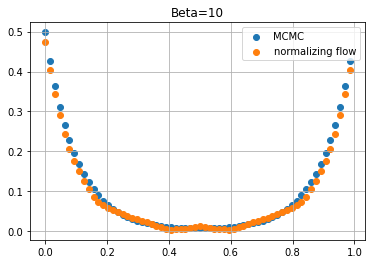

In [39]:
#import sys
#sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
from NFconstants import N_nod, N_traj, NG_points,Beta
#from Value import G
#import ensemble
#from NFoscillator import basic_oscillator
#from time import time
#from NFandist import calc_G

"""
ens_nf=ensemble.ensemble.load("nf_ensemble.txt",basic_oscillator)
g_nf=np.vstack(ensemble.ensemble.Vaverage_and_sigma(ens_nf,G))
g_nf=g_nf.transpose()[0]
"""

g=g_osc
print(g_nf[0])
fig=plt.figure()
MCMC_list=np.arange(len(g))/len(g)
NF_list=np.arange(len(g_nf))/len(g_nf)
plt.scatter(MCMC_list,g)
plt.scatter(NF_list,g_nf)
#plt.scatter(NF_list,g4_nf)
plt.legend(["MCMC","normalizing flow"])
#plt.legend(["normalizing flow"])
plt.title("Beta=10")
plt.grid(True)
plt.show()


In [54]:


! du -sh logs






1.4G	logs


In [ ]:
! rm -rf logs


NameError: name 'N_nod' is not defined

tensor([1, 2, 3, 4, 1, 1, 1, 1, 1])
tensor([ 1,  4,  9, 16,  1,  1,  1,  1,  1])
tensor([ 1.0000,  4.0000,  9.0000, 16.0000,  0.2000,  0.1667,  0.1429,  0.1250,
         0.1111])


In [ ]:
from tqdm import tqdm
N_samp=100
N_s=10000
d=(a/N_nod)**0.5

system=osc
model=RG_trained


S_new=torch.zeros(N_samp)
y=torch.zeros(N_samp)
ind=torch.zeros(N_samp)
mask=torch.zeros(N_samp)


normal_dist=torch.distributions.Normal(loc=torch.zeros(N_nod), scale=torch.ones(N_nod))
uniform_dist=torch.distributions.Uniform(torch.zeros(N_nod), torch.ones(N_nod))
un=torch.distributions.Uniform(0, 1)

z=normal_dist.sample((N_samp,))
x1=model(z)
print(torch.mean(x1**2))
#S=system.Full_S(z)
S=system.Full_S(model(z))

for i in tqdm(range(N_s)):
    if i%100==0:
        x1=model(z)
        print(torch.mean(x1**2))
    
    shift=uniform_dist.sample((N_samp,))
    y=z+d*(2*shift-1)
    #S_new=system.Full_S(y)
    x=model(y)
    S_new=system.Full_S(x)
    ind=un.sample((N_samp,))<torch.exp(S-S_new)
    mask=ind.nonzero()
    if len(mask)>1:
        mask=mask.squeeze()
    if  len(mask)>0:
        S[mask]=S_new[mask]
        z[mask,:]=y[mask,:]
       
    
    

tensor(0.4898, grad_fn=<MeanBackward0>)


  0%|          | 1/10000 [00:00<19:39,  8.48it/s]

tensor(0.4898, grad_fn=<MeanBackward0>)


  1%|          | 98/10000 [00:05<08:11, 20.14it/s]

tensor(0.4863, grad_fn=<MeanBackward0>)


  2%|▏         | 199/10000 [00:10<08:03, 20.29it/s]

tensor(0.4868, grad_fn=<MeanBackward0>)


  3%|▎         | 302/10000 [00:15<11:05, 14.58it/s]

tensor(0.4926, grad_fn=<MeanBackward0>)


  4%|▍         | 400/10000 [00:21<10:02, 15.94it/s]

tensor(0.5073, grad_fn=<MeanBackward0>)


  5%|▌         | 500/10000 [00:27<09:23, 16.87it/s]

tensor(0.5082, grad_fn=<MeanBackward0>)


  6%|▌         | 600/10000 [00:34<09:30, 16.47it/s]

tensor(0.5109, grad_fn=<MeanBackward0>)


  7%|▋         | 700/10000 [00:40<09:25, 16.45it/s]

tensor(0.4967, grad_fn=<MeanBackward0>)


  8%|▊         | 800/10000 [00:46<09:20, 16.40it/s]

tensor(0.4996, grad_fn=<MeanBackward0>)


  9%|▉         | 892/10000 [00:52<09:16, 16.37it/s]

[0;31mKernelOutOfMemory[0m: Kernel ran out of memory and has been restarted. If the restart fails, restart the kernel from the Kernel menu.
If the error persists, try choosing a different configuration or optimizing your code.

In [32]:
from tqdm import tqdm
def MCMC(system,z,model="none",d=a/N_nod,N_sweep=100):
    
    S_new=torch.zeros(N_samp)
    y=torch.zeros(N_samp)
    ind=torch.zeros(N_samp)
    mask=torch.zeros(N_samp)

    uniform_dist=torch.distributions.Uniform(torch.zeros(N_nod), torch.ones(N_nod))
    un=torch.distributions.Uniform(0, 1)

    if model=="none":
        S=system.Full_S(z)
    
    else:
        S=system.Full_S(model(z))

    for i in tqdm(range(N_sweep)):
        if i%100==0:
            if model=="none":
                print(torch.mean(z**2))
            else:    
                x1=model(z)
                print(torch.mean(x1**2))
    
        shift=uniform_dist.sample((N_samp,))
        y=z+d*(2*shift-1)
        if model=="none":
            S_new=system.Full_S(y)
        else:    
            x=model(y)
            S_new=system.Full_S(x)
        
        ind=un.sample((N_samp,))<torch.exp(S-S_new)
        mask=ind.nonzero()
        if len(mask)>1:
            mask=mask.squeeze()
        if  len(mask)>0:
            S[mask]=S_new[mask]
            z[mask,:]=y[mask,:]
    return z    
    
    

In [33]:
N_samp=100
z=normal_dist.sample((N_samp,))
z=MCMC(osc,z,model=RG_trained,d=2*(a/N_nod)**0.5,N_sweep=800)

  0%|          | 0/800 [00:00<?, ?it/s]

tensor(0.4888, grad_fn=<MeanBackward0>)


 13%|█▎        | 101/800 [00:07<00:55, 12.55it/s]

tensor(0.4509, grad_fn=<MeanBackward0>)


 25%|██▌       | 201/800 [00:14<00:46, 12.75it/s]

tensor(0.4540, grad_fn=<MeanBackward0>)


 38%|███▊      | 301/800 [00:22<00:42, 11.75it/s]

tensor(0.4789, grad_fn=<MeanBackward0>)


 50%|█████     | 401/800 [00:29<00:31, 12.60it/s]

tensor(0.4790, grad_fn=<MeanBackward0>)


 62%|██████▏   | 499/800 [00:36<00:20, 14.51it/s]

tensor(0.4958, grad_fn=<MeanBackward0>)


 75%|███████▍  | 599/800 [00:43<00:14, 13.78it/s]

tensor(0.4909, grad_fn=<MeanBackward0>)


 88%|████████▊ | 701/800 [00:51<00:07, 12.56it/s]

tensor(0.4841, grad_fn=<MeanBackward0>)


100%|██████████| 800/800 [00:58<00:00, 13.71it/s]


In [34]:
from NFandist import get_T
import numpy as np
T=torch.tensor(get_T(N_nod)).float()
N_trajs=N_samp
def G(X,n_p=N_nod):
    G=np.zeros((n_p))
    Y=X.clone()
    Xt=torch.t(X)
    for s in range(n_p):
        G[s]=torch.trace(torch.matmul(Y,Xt))
        Y=torch.matmul(Y,T)
    return G/(N_trajs*N_nod)

In [38]:
from NFandist import calc_G
from NFconstants import N_nod, N_traj, NG_points,Beta
g_osc=calc_G(N_nod,Beta,N_nod)
g_nf=G(RG_trained(z))
print(g_nf-g_osc)

[-0.02455711 -0.02226591 -0.02064708 -0.02208949 -0.02232602 -0.02140337
 -0.01885054 -0.01764022 -0.01848675 -0.01718338 -0.01876166 -0.01715795
 -0.01211077 -0.00842408 -0.00416224 -0.00082487  0.00146886  0.00200574
  0.00290767  0.00370823  0.00359793  0.00269677  0.00099806 -0.00048782
 -0.00268798 -0.00506714 -0.00673628 -0.00408253 -0.00336264 -0.00156277
  0.00167851  0.00432041  0.00559031  0.00432042  0.00167851 -0.00156276
 -0.00336264 -0.00408254 -0.00673628 -0.00506714 -0.00268798 -0.00048782
  0.00099806  0.00269677  0.00359792  0.00370824  0.00290767  0.00200574
  0.00146886 -0.00082487 -0.00416224 -0.00842408 -0.01211077 -0.01715795
 -0.01876166 -0.01718338 -0.01848675 -0.01764022 -0.01885054 -0.02140337
 -0.02232602 -0.02208949 -0.02064708 -0.02226591]
